# Determining Population Densities and Intramicellar Distributions by Contrast Variation SANS

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve with soft ball P(Q) in J. Chem. Phys. 153, 184902 (2020)
# Calculate polymer distribution by contrast variation
#
# tensorflow 2.6.0

## Setup

Ensure you have installed these packages first  
``$ pip install tensorflow-probabilit``  
``$ pip install imageio``  
``$ pip install git+https://github.com/tensorflow/docs``  

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
tf.config.run_functions_eagerly(True)

## Define functions

### Load data

In [3]:
def is_header(x):
    n_header = 5
    return x>=n_header

In [4]:
def loaddata(filename):
    filename = data_path + 'S2_{:03d}.ABS'.format(contrast)
    with open(filename,'r') as fp:
        lines = fp.readlines()

    index_all = range(len(lines))
    index = list(filter(is_header, index_all))
    
    lines_data = list(itemgetter(*index)(lines))
    
    data_dict = {}
    for j, ld in enumerate(lines_data):
        raw_fields = struct_unpacker(ld.encode())
        ld_unpacked = {}
        for i in field_indices:
            fieldspec = fieldspecs[i]
            fieldname = fieldspec[iname]
            cast = fieldspec[itype]
            value = cast(raw_fields[i].decode().strip())
            ld_unpacked[fieldname] = [value]
        if j==0:
            data_dict = ld_unpacked
            continue
        data_dict = {key: [*data_dict[key], *ld_unpacked[key]] for key in data_dict}
    
    return data_dict

In [5]:
def get_struct_unpacker(fieldspecs, istart, iwidth):
    # https://gist.github.com/rochacbruno/059e1223f5b69d3b99b509a4962cf3aa
    """
    Build the format string for struct.unpack to use, based on the fieldspecs.
    fieldspecs is a list of [name, start, width] arrays.
    Returns a string like "6s2s3s7x7s4x9s".
    """
    unpack_len = 0
    unpack_fmt = ""
    for fieldspec in fieldspecs:
        start = fieldspec[istart] - 1
        end = start + fieldspec[iwidth]
        if start > unpack_len:
            unpack_fmt += str(start - unpack_len) + "x"
        unpack_fmt += str(end - start) + "s"
        unpack_len = end
    struct_unpacker = struct.Struct(unpack_fmt).unpack_from
    return struct_unpacker

In [6]:
from operator import itemgetter
import struct

fieldspecs = [
    # Name, Start, Width, Type
    ["Q (1/A)", 8, 8, float],
    ["I(Q) (1/cm)", 26, 6, float],
    ["std. dev. I(Q) (1/cm)", 40, 8, float],
    ["sigmaQ", 55, 9, float],
    ["meanQ", 72, 8, float],
    ["ShadowFactor", 95, 1, int]
]

iname, istart, iwidth, itype = 0, 1, 2, 3  # field indexes

fieldspecs.sort(key=itemgetter(istart))
struct_unpacker = get_struct_unpacker(fieldspecs, istart, iwidth)
field_indices = range(len(fieldspecs))

### Fit curve

In [7]:
def softball(Q, fp):
    R1, R2, sigma1, sigma2, rc = fp[2:7]
    j1 = lambda QR: (tf.math.sin(QR)-QR*tf.math.cos(QR))/QR**2
    F1 = lambda QR, Qsigma: 3*j1(QR)*tf.math.exp(-(Qsigma/2)**2)/QR
    
    QR1 = Q*R1
    QR2 = Q*R2
    Qsigma1 = Q*sigma1
    Qsigma2 = Q*sigma2
    
    P = (rc*F1(QR1,Qsigma1) + (1-rc)*F1(QR2,Qsigma2))**2
    
    return P

In [8]:
def fit_loss(fp, Q, IQ, IQ_err):
    P = softball(Q, fp)
    IQ_th = fp[0]*P + fp[1]
    
    # mean-square error
    IQ_th_log = tf.math.log(IQ_th)
    IQ_log = tf.math.log(IQ)
    index = (Q>0.02)&(Q<0.5)
    err = tf.reduce_mean((IQ_th_log[index]-IQ_log[index])**2)
    
    d_IQ = tf.reduce_max(IQ_log[index])-tf.reduce_min(IQ_log[index])
    err_r = err/d_IQ
    
    return err_r

In [9]:
@tf.function
def train_step(fp, Q, IQ, IQ_err, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = fit_loss(fp, Q, IQ, IQ_err)
    gradients = tape.gradient(loss, fp)
    optimizer.apply_gradients(zip(gradients, fp))

In [10]:
def initialize():
    # tf.constant("Initial Guess")
    i_A = tf.constant(1.5)
    i_B = tf.constant(0.04)
    i_R1 = tf.constant(25.0)
    i_R2 = tf.constant(60.0)
    i_sigma1 = tf.constant(15.0)
    i_sigma2 = tf.constant(20.0)
    i_rc = tf.constant(0.4)
    
    # constraint=lambda t: tf.clip_by_value(t, "Lower Bound", "Upper Bound")
    A = tf.Variable(i_A, name='A', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, 2))
    B = tf.Variable(i_B, name='B', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, 1))
    R1 = tf.Variable(i_R1, name='R1', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, R2))
    R2 = tf.Variable(i_R2, name='R2', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, R1, 100))
    sigma1 = tf.Variable(i_sigma1, name='sigma1', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 10, 20))
    sigma2 = tf.Variable(i_sigma2, name='sigma2', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 10, 50))
    rc = tf.Variable(i_rc, name='rc', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 0, 1))
    
    fp_i = [A, B, R1, R2, sigma1, sigma2, rc]
    return fp_i

In [11]:
def generate_image(ax, filename, fp, Q, IQ, IQ_err, counter):
    P = softball(Q, fp)
    IQ_th = fp[0]*P + fp[1]
    loss = fit_loss(fp, Q, IQ, IQ_err)
       
    ax.clear()
    
    ax.errorbar(Q, IQ, yerr=IQ_err, fmt=',k', elinewidth=1, capsize=2)
    ax.plot(Q, IQ_th, 'b')
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlim(0.02, 0.5)
    plt.ylim(0.02, 2)
    
    plt.text(0.05,0.12,'A = {:0.4f}, B = {:0.4f}, R1 = {:0.4f}, R2 = {:0.4f}'
             .format(fp[0].numpy(),fp[1].numpy(),fp[2].numpy(),fp[3].numpy())
             ,transform=ax.transAxes)
    plt.text(0.05,0.06,'sigma1 = {:0.4f}, sigma2 = {:0.4f}, rc = {:0.4f}'
             .format(fp[4].numpy(),fp[5].numpy(),fp[6].numpy())
             ,transform=ax.transAxes)
    plt.text(0.80,0.95,'loss = {:0.4f}'
             .format(loss.numpy())
             ,transform=ax.transAxes)
    
    fig.canvas.draw()
    #time.sleep(0.01)

-----

In [12]:
%matplotlib notebook

loaded ../data/S2/S2_080.ABS


<IPython.core.display.Javascript object>


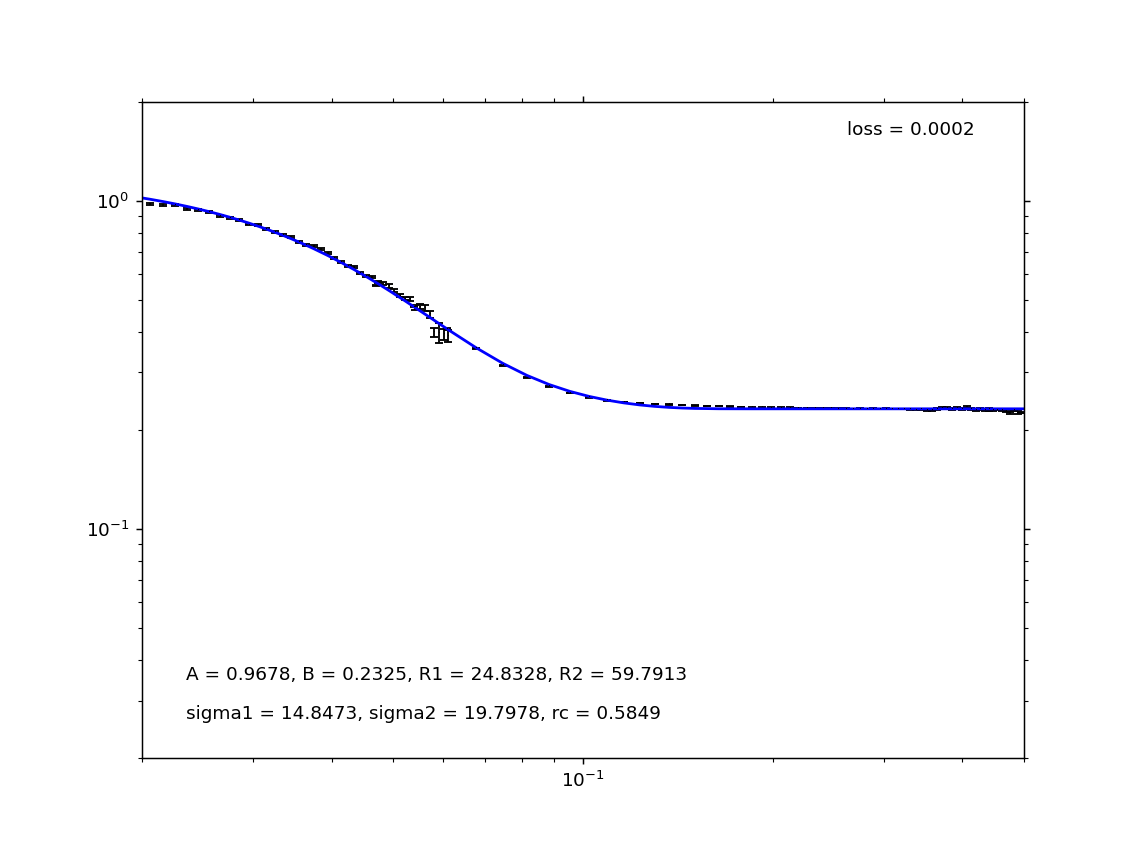

In [13]:
data_path = '../data/S2/'
contrasts = np.array([100, 95, 90, 85, 80, 75])

for i, contrast in enumerate(contrasts[4:5]):
    # Load data
    filename = data_path + 'S2_{:03d}.ABS'.format(contrast)
    data_dict = loaddata(filename)
    print('loaded '+ filename)
    
    Q = np.array(data_dict['Q (1/A)']).astype(np.float32)
    IQ = np.array(data_dict['I(Q) (1/cm)']).astype(np.float32)
    IQ_err = np.array(data_dict['std. dev. I(Q) (1/cm)']).astype(np.float32)
    
    # Fit
    fp = initialize()
    loss = fit_loss(fp, Q, IQ, IQ_err)
    optimizer = tf.keras.optimizers.Adam(0.01) # set train rate HERE
    
    max_iter = 1000 # set maxiter HERE
    counter = 0
    fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
    generate_image(ax, filename, fp, Q, IQ, IQ_err, counter)
    
    while loss > 1e-4:
        try:
            counter += 1
            if counter>max_iter:
                break
            
            loss = fit_loss(fp, Q, IQ, IQ_err)
            train_step(fp, Q, IQ, IQ_err, optimizer)
            if counter%5==0:
                generate_image(ax, filename, fp, Q, IQ, IQ_err, counter)
                
        except KeyboardInterrupt:
            break
            

## Under construction

In [14]:
generate_image(ax, filename, fp, Q, IQ, IQ_err, counter)

In [15]:
print('current fp: A = {:04f}, B = {:04f}, R1 = {:04f}, R2 = {:04f}, sigma1 = {:04f}, sigma2 = {:04f}, rc = {:04f}'
                  .format(fp[0].numpy(),fp[1].numpy(),fp[2].numpy(),fp[3].numpy(),fp[4].numpy(),fp[5].numpy(),fp[6].numpy()))

current fp: A = 0.967765, B = 0.232478, R1 = 24.832762, R2 = 59.791275, sigma1 = 14.847310, sigma2 = 19.797758, rc = 0.584946


In [16]:
IQ_err

array([0.1401   , 0.05163  , 0.0305   , 0.02146  , 0.01668  , 0.0137   ,
       0.01207  , 0.01114  , 0.01043  , 0.009816 , 0.009383 , 0.009127 ,
       0.008807 , 0.008437 , 0.008111 , 0.007886 , 0.00751  , 0.007396 ,
       0.007162 , 0.007021 , 0.00678  , 0.00663  , 0.006492 , 0.006303 ,
       0.006092 , 0.006017 , 0.005876 , 0.00567  , 0.005538 , 0.005425 ,
       0.005286 , 0.005201 , 0.005053 , 0.004917 , 0.004782 , 0.004738 ,
       0.004621 , 0.004539 , 0.004476 , 0.004447 , 0.004438 , 0.004567 ,
       0.004603 , 0.004798 , 0.004989 , 0.001202 , 0.005081 , 0.005415 ,
       0.005833 , 0.006131 , 0.00627  , 0.006538 , 0.007224 , 0.001047 ,
       0.007766 , 0.008869 , 0.00942  , 0.01123  , 0.01301  , 0.02806  ,
       0.01444  , 0.0009153, 0.01642  , 0.0008126, 0.0007318, 0.000673 ,
       0.0006275, 0.0005927, 0.0005619, 0.0005386, 0.0005193, 0.0005019,
       0.0004883, 0.0004747, 0.0004612, 0.000451 , 0.0004422, 0.0004296,
       0.000422 , 0.0004127, 0.0004048, 0.0003979, 